In [ ]:
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/rbroc/personality_reddit/blob/triplet_loss/subreddit_pushshift_triplet_tpu.ipynb)

In [1]:
!pip install transformers

     |████████████████████████████████| 1.5MB 6.6MB/s 
     |████████████████████████████████| 2.9MB 21.4MB/s 
     |████████████████████████████████| 890kB 54.3MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=66f56e3b1dfb9abf31900dc91ad140470e98f8cd50f8c7e74badb0058da1bac5
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [2]:
# TRAINING OPTIONS:
# Run on TPU with smaller batches 
# OR 
# Switch to GPU if possible (MirroredStrategy), more memory needed

# To DOS
# Average loss over batches (not feasible in Colab TPU - memory issue)
# Implement validation step
# Play with hyperparameters (learning rate, margin)
# Read up on dynamic margin?

# OTHER:
# Set up other model (N1)
# Set up baseline model (BoW)
# Set up checkpoints
# Why does the bar not update?

# TRIPLET MINING:
# Refine dataset building, creating hard vs. semi-hard triplets (same vs. different subreddit?)
# and computing loss on subsets of these

# GENERAL ISSUES
# How to evaluate? Loss is not so informative.
# Better / more informed dataset building (e.g. exploiting same vs. different subreddit?)
# Better / more informed loss calculation (e.g. only for "hard" triplets?)
# Better dataset inspection (make it possible to pull out negative/positive pair text - maybe embed tokenization in dataset building?)

In [3]:
from tensorflow import keras
import tensorflow as tf
import numpy as np
import keras.backend as K
from tensorflow.keras import layers, Input
from transformers import TFDistilBertModel
import glob
from tqdm import tqdm
from tensorflow.keras.utils import Progbar
from google.colab import drive
import os

In [4]:
drive.mount('/content/drive/')
%cd 'drive/My Drive/personality_reddit'

Mounted at /content/drive/
/content/drive/My Drive/personality_reddit


In [5]:
from tools.datasets import load_tfrecord_triplet_nn1

In [ ]:
try:
  tpu_address = 'grpc://' + os.environ['COLAB_TPU_ADDR']
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver(tpu_address)
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.experimental.TPUStrategy(tpu)
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])  
  print("Number of accelerators: ", strategy.num_replicas_in_sync)
except ValueError:
  print('TPU failed to initialize.')

INFO:absl:Entering into master device scope: /job:worker/replica:0/task:0/device:CPU:0


INFO:tensorflow:Initializing the TPU system: grpc://10.93.166.58:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.93.166.58:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Running on TPU  ['10.93.166.58:8470']
Number of accelerators:  8


In [ ]:
AUTO = tf.data.experimental.AUTOTUNE

## Load and split dataset

In [ ]:
batch_size = 8 # >1 not feasible on Colab TPUs - crashes at 10Gb requirement
global_batch_size = batch_size * strategy.num_replicas_in_sync
n_posts = 30
samples_in_toy_dataset = 1000

In [ ]:
from google.colab import auth
auth.authenticate_user()
!gcloud config set project thematic-cursor-254011

Updated property [core/project].


In [ ]:
fre = 'gs://personality_reddit/triplet_nn1/*-of-999.tfrecord'
fnames = tf.io.gfile.glob(fre)

In [ ]:
ds_triplet = load_tfrecord_triplet_nn1(filenames=fnames,
                                       deterministic=False,
                                       num_parallel_calls=AUTO)

In [ ]:
ds_triplet = ds_triplet.map(lambda x: x['input_ids'][:n_posts, :])
ds_triplet = ds_triplet.map(lambda x: tf.reverse(x, [0]))
ds_triplet = ds_triplet.prefetch(AUTO).padded_batch(global_batch_size, padded_shapes=[n_posts, None])

In [ ]:
input_ids = Input(shape=(None, 512), 
                  dtype='int32', 
                  name='input_ids')

In [ ]:
n_examples = 167320
n_train = int(167320 * .7)
n_val = int(167320 * .1)
n_test = 167320 - (n_train + n_val)

In [ ]:
ds_small = ds_triplet.take(samples_in_toy_dataset)
##ds_train = ds_triplet.take(n_train)
#ds_test = ds_triplet.skip(n_train + n_val)
#ds_val = ds_triplet.skip(n_train).take(n_val)

In [ ]:
ds_small = strategy.experimental_distribute_dataset(ds_small)
#ds_train = strategy.experimental_distribute_dataset(ds_train)
#ds_val = strategy.experimental_distribute_dataset(ds_val)
#ds_test = strategy.experimental_distribute_dataset(ds_test)

# Define model

In [ ]:
class CustomBertLayer(keras.Model):
  def __init__(self, model, name=None, trainable=True):
    super(CustomBertLayer, self).__init__(name=name)
    self.model = model
    self.trainable = trainable
    self.output_signature = tf.float32

  def call(self, input):
    def red_fn(x):
      enc = self.model(x).last_hidden_state[:,0,:]
      mask = tf.cast(tf.not_equal(tf.reduce_mean(x, axis=1), 0), 
                     tf.float32)
      masked = tf.multiply(enc, tf.expand_dims(mask, 1))
      return masked

    enc = tf.vectorized_map(lambda x: red_fn(x),
                               elems=input)#, 
    #                           parallel_iterations=strategy.num_replicas_in_sync,
    #                           dtype=self.output_signature)
    return enc

In [ ]:
def triplet_loss(margin):
  def loss_fn(enc):

    n_emb = enc[:,0,:]
    p_emb = enc[:,1,:]
    cnt = tf.math.count_nonzero(tf.reduce_mean(enc[:,2:,:], axis=-1), axis=1)
    cnt = tf.expand_dims(tf.cast(cnt, tf.float32), 1)
    a_emb = tf.divide(tf.reduce_sum(enc[:,2:,:], axis=1), cnt)

    d_pos = tf.reduce_sum(tf.square(a_emb - p_emb), 1)
    d_neg = tf.reduce_sum(tf.square(a_emb - n_emb), 1)
    loss_val = tf.maximum(0.0, margin + d_pos - d_neg)
    loss_val = tf.reduce_mean(loss_val) # avg batch

    return loss_val
  return loss_fn

## Training protocol

In [ ]:
loss_margin = 10 #0.0002
learning_rate = 10e-5

In [ ]:
with strategy.scope():

  encoder_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')
  encoder_model.trainable = True
  
  encs = CustomBertLayer(encoder_model)(input_ids)
  model = keras.Model(input_ids, encs)
  model.trainable = encoder_model.trainable 

  loss_obj = triplet_loss(loss_margin)
  optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

  def compute_loss(enc):
    l = loss_obj(enc)
    return tf.math.divide(l, strategy.num_replicas_in_sync)

  @tf.function
  def distributed_train_step(dataset_inputs):
    pr_losses, pr_metrics = strategy.run(train_step, args=(dataset_inputs,))
    red_fn = lambda x: strategy.reduce(tf.distribute.ReduceOp.SUM, x, axis=None)
    return red_fn(pr_losses), red_fn(pr_metrics)

  def train_step(inputs):
    with tf.GradientTape() as tape:
      enc = model(inputs)
      loss = compute_loss(enc)
      mtr = tf.maximum(loss - loss_margin, 0.)
      gradients = tape.gradient(loss, model.trainable_variables)
      optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss, mtr

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_transform', 'activation_13', 'vocab_projector', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.
The parameters `output_attentions`, `output_hidden_states` and `use_cach

In [ ]:
# Set number of epochs and n examples (for progress bar)
EPOCHS = 1
n_examples = 1000

# Run training loop
with strategy.scope():
  for epoch in range(EPOCHS):

    pb_i = Progbar(n_examples, stateful_metrics=['loss', 'correct'])
    tf.print(f'Epoch {int(epoch)}')

    epoch_losses = []
    epoch_metrics = []
    num_batches = 0

    for x in ds_small:
      num_batches += 1
      loss, correct = distributed_train_step(x)#, num_batches)
      epoch_losses.append(loss)
      epoch_metrics.append(correct)
      pb_i.add(1, values=[('loss', loss), ('correct', correct)])

In [ ]:
import seaborn as sns
from matplotlib import pyplot as plt
sns.scatterplot(x=range(len(epoch_metrics)), 
                y=[e.numpy() for e in epoch_losses])
#plt.yscale('log')
plt.title('Epoch 1')
plt.xlabel('step')
plt.ylabel('loss')
plt.ylim(0,0.05)
plt.show()

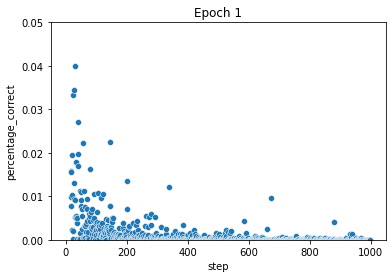

In [ ]:
import seaborn as sns
from matplotlib import pyplot as plt
sns.scatterplot(x=range(len(epoch_metrics)), y=[e.numpy() for e in epoch_metrics])
plt.title('Epoch 1')
plt.xlabel('step')
plt.ylabel('percentage_correct')
plt.ylim(0, 0.05)
plt.show()

In [ ]:
# Try eval on other